<a href="https://colab.research.google.com/github/campbeh3/PHYS486-S22/blob/main/Final%20Project/StatStar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

########################################################################################################################
######                                                                                                            ######
######        TAKEN FROM http://spiff.rit.edu/classes/phys370/lectures/statstar/statstar.html,                    ######
######        which was given to me by Kevin. The code was originally written in FORTRAN and                      ######
######        was transcribed into python by Professor D. Schiminovich at Columbia University.                    ######
######                                                                                                            ######
######        Also note: This code is very difficult to follow. I'm trying my best to understand it myself,       ######
######        and I'm adding comments to make it more understandable, but don't worry if it doesn't make sense.   ######
######        The important part, for now, is that it works!                                                      ######
######                                                                                                            ######
########################################################################################################################


#  statstar.py
#
#  This program is a Python version of the code STATSTAR written
#  in FORTRAN and described in Carroll and Ostlie.  Program
#  has been modified and converted to Python in Fall 2010 
#  by Prof. D. Schiminovich at Columbia University 
#  for use in C3101 Stellar Structure and Evolution
#
#  Notes from FORTRAN code:
#
#  This program is listed in Appendix H of both "An Introduction
#  to Modern Astrophysics," Bradley W. Carroll and Dale A. Ostlie,
#  Addison-Wesley Publishing Company, copyright 1996, and "An 
#  Introduction to Modern Stellar Astrophysics," Dale A. Ostlie
#  and Bradley W. Carroll, Addison-Wesley Publishing Company,
#  copyright 1996.
#
#  This program will calculate a static stellar model using the 
#  equations developed in the text.  The user is expected to supply the
#  star's mass, luminosity, effective temperature, and composition 
#  (X and Z).  If the choices for these quantities are not consistent 
#  with the central boundary conditions, an error message will be 
#  generated and the user will then need to supply a different set of
#  initial values.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
### This variable changes which form of the EOS function is used.
### Set it to 'y' if you want to model pre-main-sequence stars,
### and set it to 'n' if you want main-sequence stars.
Birthline = 'y'

#Birthline = input('Is this star on the birthline (y/n)? ') #Comment this in if you want to be prompted whether the star is on the birthline or not


# Set constants used everywhere

#Stefan-Boltzmann Constant
sigma=5.67051e-5

# Speed of light
c=2.99792458e10

#4*sigma/c (radiation pressure constant)
a=7.56591e-15

#Gravitational Constant
G=6.67259e-8

#K_B = Boltzmann constant
k_B=1.380658e-16

#m_H = mass of hydrogen atom 
m_H=1.673534e-24

#gamma = 5/3 (adiabatic gamma for a monatomic gas)
gamma= 5/3

#free-free opacity gaunt factor (assumed to be unity)
g_ff= 1

#  Calculate the delimiter between adiabatic convection and radiation
#  (see Prialnik Eq. 6.28 or C&O Eq. 10.87).
#
gamrat = gamma/(gamma - 1)


ierr=True # If ierr is set to False, then there is a negative temperature, pressure, or density. (Can only be set to False in the EOS function)


#kPad = P/T**(gamma/(gamma-1)) (adiabatic gas law constant)
kPad = 0.3 # I think this was arbitrary and it changes later?

In [ ]:
#  Subroutine STARTMDL computes values of M_r, L_r, P, and T, near the
#  surface of the star using expansions of the stellar structure
#  equations (M_r and L_r are assumed to be constant).

def STARTMDL(deltar, X, Z, mu, Rs, r_i, M_ri, L_ri, tog_bf,irc):
#
#     X = hydrogen mass fraction
#     Z = metal mass fraction
#     mu = mean molecular weight
#     Rs = radius of star
#     r_i = radius of shell
#     M_ri = mass enclosed within shell at this radius 
#          (assumed constant at start of model)
#     L_ri = enclosed luminosity, assumed constant
#
      r = r_i + deltar
      M_rip1 = M_ri
      L_rip1 = L_ri
#
#  This is the radiative approximation (neglect radiation pressure
#  and electron scattering opacity)# see Prialnik Eq. 5.1, 5.3 and Sec. 3.7 or C&O Eqs. (H.1), (H.2), (9.19),
#  and (9.20).
#
      if irc == True:
          T_ip1 = G * M_rip1 * mu * m_H / (4.25*k_B) * (1/r - 1/Rs)
          A_bf = 4.34e25 * Z * (1 + X) / tog_bf
          A_ff = 3.68e22 * g_ff * (1 - Z) * (1 + X)
          Afac = A_bf + A_ff
          P_ip1 = np.sqrt((1/4.25) * (16/3*np.pi * a * c) * (G * M_rip1 / L_rip1) * (k_B / (Afac * mu * m_H))) * T_ip1**4.25

#
#  This is the convective approximation# see Prialnik Sec 6.5, 6.6 or C&O Eqs. (H.3) and (10.75).
#
      else:
          T_ip1 = G * M_rip1 * mu * m_H/k_B * (1/r - 1/Rs) / gamrat
          P_ip1 = kPad*T_ip1**gamrat

      return r,P_ip1, M_rip1, L_rip1, T_ip1


In [ ]:
#  Subroutine EOS calculates the values of density, opacity, the 
#  guillotine-to-gaunt factor ratio, and the energy generation rate at
#  the radius r.

def EOS(X, Z, XCNO, mu, P, T,izone):

#
#  Solve for density from the ideal gas law (remove radiation pressure)#
#  see Prialnik Eq. 5.5 or C&O Eq. (10.26).
#
      if T < 0 or P < 0:
          print(' Something is a little wrong here.')
          print(' You are asking me to deal with either a negative temperature')
          print(' or a negative pressure.  I am sorry but that is not in my')
          print(' contract! You will have to try again with different')
          print(' initial conditions.')
          print(' In case it helps, I detected the problem in zone ',izone)
          print(' with the following conditions:')
          print('T = ',T,' K')
          print('P = ',P,' dynes/cm**2')
          ierr = False
          return 0, 0, 0, 0


      Prad = a * T**4/3
      Pgas = P - Prad
      rho=(mu*m_H/k_B)*(Pgas/T)
      if rho < 0:
          print(' I am sorry, but a negative density was detected.')
          print(' my equation-of-state routine is a bit baffled by this new')
          print(' physical system you have created.  The radiation pressure')
          print(' is probably too great, implying that the star is unstable.')
          print(' Please try something a little less radical next time.')
          print(' In case it helps, I detected the problem in zone ')
          print(' with the following conditions:')
          print('T       = {0:12.5E} K'.format(T))
          print('P_total = {0:12.5E} dynes/cm**2'.format(P))
          print('P_rad   = {0:12.5E} dynes/cm**2'.format(Prad))
          print('P_gas   = {0:12.5E} dynes/cm**2'.format(Pgas))
          print('rho     = {0:12.5E} g/cm**3'.format(rho))
          ierr = False
          return rho, 0, 0, 0

#
#  Calculate opacity, including the guillotine-to-gaunt factor ratio#
#  see Novotny (1973), p. 469. k_bf, k_ff, and k_e are the bound-free,
#  free-free, and electron scattering opacities, given by Prialnik Sec 3.7 or C&O Eqs. (9.19),
#  (9.20), and (9.21), respectively.
#

      tog_bf = 2.82 * (rho*(1 + X))**0.2
      k_bf = 4.34e25 / tog_bf * Z * (1 + X) * rho / T**3.5
      k_ff = 3.68e22 * g_ff * (1 - Z) * (1 + X) * rho / T**3.5
      k_e = 0.2*(1 + X)
      kappa = k_bf + k_ff + k_e
#
#  Compute energy generation by the pp chain and the CNO cycle.  These
#  are calculated using Eqs. (10.49) and (10.53) Prialnik Eq. 4.6, 4.7 + screening factor, which come from
#  Fowler, Caughlan, and Zimmerman (1975). The screening factor for the
#  pp chain is calculated as fpp# see Clayton (1968), p. 359ff.
#
#     Calculate 1/3 and 2/3 for convenience
      oneo3=0.333333333
      twoo3=0.666666667

      T6 = T*1.0e-06
      fx = 0.133 * X * np.sqrt((3 + X) * rho) / T6**1.5
      fpp = 1 + fx*X
      psipp = 1 + 1.412e8 * (1/X - 1) * np.exp(-49.98 * T6**((-1)*oneo3))
      Cpp = 1 + 0.0123 * T6**oneo3 + 0.0109 * T6**twoo3 + 0.000938*T6
      epspp = 2.38e6*rho * X*X * fpp * psipp * Cpp * T6**(-twoo3) * np.exp(-33.8 * T6**(-oneo3))
      CCNO = 1 + 0.0027 * T6**oneo3 - 0.00778 * T6**twoo3- 0.000149*T6
      epsCNO = 8.67e27*rho * X * XCNO * CCNO * T6**(-twoo3) * np.exp(-152.28*T6**(-oneo3))
      epslon = epspp + epsCNO

      return rho, kappa, epslon,tog_bf






In [ ]:
#  Subroutine EOS calculates the values of density, opacity, the 
#  guillotine-to-gaunt factor ratio, and the energy generation rate at
#  the radius r.

def EOS_Birthline(X, Z, XCNO, mu, P, T, izone, Ms, Rs):

#
#  Solve for density from the ideal gas law (remove radiation pressure)#
#  see Prialnik Eq. 5.5 or C&O Eq. (10.26).
#
      if T < 0 or P < 0:
          print(' Something is a little wrong here.')
          print(' You are asking me to deal with either a negative temperature')
          print(' or a negative pressure.  I am sorry but that is not in my')
          print(' contract! You will have to try again with different')
          print(' initial conditions.')
          print(' In case it helps, I detected the problem in zone ',izone)
          print(' with the following conditions:')
          print('T = ',T,' K')
          print('P = ',P,' dynes/cm**2')
          ierr = False
          return 0, 0, 0


      # Calculates the density using the polytropic equation of state P = K * rho**(1+1/n)
      # where K is a constant and n is the polytropic index
      # This formula was found here: https://people.ast.cam.ac.uk/~phewett/SandES2017/Lec2017_15.pdf

      n = 1.5 # n is the polytropic index, and describes the relationship between the density and pressure of the medium

      Cn = (4*np.pi*Rs**(n-3)) / ((n+1)**n * Ms**(n-1))

      K_to_the_n = Cn * G**n * Ms**(n-1) * Rs**(3-n)

      K = K_to_the_n **(1/n)

      rho = (P/K)**(1/(1+1/n))



#
#  Calculate opacity, including the guillotine-to-gaunt factor ratio#
#  see Novotny (1973), p. 469. k_bf, k_ff, and k_e are the bound-free,
#  free-free, and electron scattering opacities, given by Prialnik Sec 3.7 or C&O Eqs. (9.19),
#  (9.20), and (9.21), respectively.
#

      tog_bf = 2.82 * (rho*(1 + X))**0.2
      k_bf = 4.34e25 / tog_bf * Z * (1 + X) * rho / T**3.5
      k_ff = 3.68e22 * g_ff * (1 - Z) * (1 + X) * rho / T**3.5
      k_e = 0.2*(1 + X)
      kappa = k_bf + k_ff + k_e


      # Energy generation (epsilon) is 0 because the protostar is not fusing!
      # Need to change dLdr to be independent of epsilon


      oneo3=0.333333333
      twoo3=0.666666667

      T6 = T*1.0e-06
      fx = 0.133 * X * np.sqrt((3 + X) * rho) / T6**1.5
      fpp = 1 + fx*X
      psipp = 1 + 1.412e8 * (1/X - 1) * np.exp(-49.98 * T6**((-1)*oneo3))
      Cpp = 1 + 0.0123 * T6**oneo3 + 0.0109 * T6**twoo3 + 0.000938*T6
      epspp = 2.38e6*rho * X*X * fpp * psipp * Cpp * T6**(-twoo3) * np.exp(-33.8 * T6**(-oneo3))
      CCNO = 1 + 0.0027 * T6**oneo3 - 0.00778 * T6**twoo3- 0.000149*T6
      epsCNO = 8.67e27*rho * X * XCNO * CCNO * T6**(-twoo3) * np.exp(-152.28*T6**(-oneo3))
      epslon = epspp + epsCNO
      

      return rho, kappa, tog_bf



In [ ]:
#  The following four function subprograms calculate the gradients of
#  pressure, mass, luminosity, and temperature at r.

def dPdr(r, M_r, rho):
      return -G * rho * M_r / r**2

def dMdr(r, rho):
      return 4 * np.pi * rho * r**2

def dLdr(r, rho, epslon):
      return 4*np.pi * rho * epslon * r**2

def dTdr(r, M_r, L_r, T, rho, kappa, mu, irc):
      if irc == True:
          return -(3/(16*np.pi * a * c)) * kappa * rho / T**3 * L_r / r**2
#  This is the adiabatic convective temperature gradient (Prialnik Eq. 6.29 or C&O Eq. 10.81).
      else:
          return -1 / gamrat * G * M_r / r**2 * mu * m_H / k_B

def dLdr_Birthline(r, deltar, T, rho, M_r):


      #return 4*np.pi * rho * epslon * r**2
      
      #Mass of one shell
      dM = 4*np.pi * rho * r**2

      #Gravitational Potential Energy Equation
      Grav_energy = (G * M_r * dM) / r

      delta_t = 10e5 # In years

      # Power generated 
      Power = Grav_energy / delta_t

      energy = (Power/rho)/deltar

      return 4*np.pi * rho * energy * r**2



In [ ]:
# Runge-kutta algorithm

def RUNGE(f_im1, dfdr, r_im1, deltar, irc, X, Z, XCNO,mu, izone, Ms, Rs):

      f_temp=np.zeros(4)
      f_i=np.zeros(4)

      dr12 = deltar/2.0
      dr16 = deltar/6.0
      r12  = r_im1 + dr12
      r_i  = r_im1 + deltar
#
#  Calculate intermediate derivatives from the four fundamental stellar
#  structure equations found in Subroutine FUNDEQ.
#
      for i in range(0,4):
          f_temp[i] = f_im1[i] + dr12*dfdr[i]

      df1 = FUNDEQ(r12, f_temp, irc, X, Z, XCNO, mu, izone, deltar, Ms, Rs)
      if ierr != True:
          return f_i
#

      for i in range(0,4):
          f_temp[i] = f_im1[i] + dr12*df1[i]

      df2 = FUNDEQ(r12, f_temp, irc, X, Z, XCNO, mu, izone, deltar, Ms, Rs)
      if ierr != True:
          return f_i

#
      for i in range(0,4):
          f_temp[i] = f_im1[i] + deltar*df2[i]

      df3 =FUNDEQ(r_i, f_temp, irc, X, Z, XCNO, mu, izone, deltar, Ms, Rs)
      if ierr != True:
          return f_i
#
#  Calculate the variables at the next shell (i + 1).
#
      for i in range(0,4):
          f_i[i] = f_im1[i] + dr16*(dfdr[i] + 2*df1[i] + 2*df2[i] + df3[i])

      return f_i

In [ ]:
#  This subroutine returns the required derivatives for RUNGE, the
#  Runge-Kutta integration routine.
#
#      Subroutine FUNDEQ(r, f, irc, X, Z, XCNO, mu, izone)

def FUNDEQ(r,f,irc,X,Z,XCNO,mu,izone, deltar, Ms, Rs):

      dfdr=np.zeros(4)
      P   = f[0]
      M_r = f[1]
      L_r = f[2]
      T   = f[3]

      if Birthline == 'y':
        rho,kappa,tog_bf = EOS_Birthline(X, Z, XCNO, mu, P, T, izone, Ms, Rs)
      else:
        rho,kappa,epslon,tog_bf = EOS(X, Z, XCNO, mu, P, T, izone)
        
      dfdr[0] = dPdr(r, M_r, rho)
      dfdr[1] = dMdr(r, rho)

      #dfdr[2] = dLdr(r, rho, epslon)

      if Birthline == 'y':
        dfdr[2] = dLdr_Birthline(r, deltar, T, rho, M_r)
      else:
        dfdr[2] = dLdr(r, rho, epslon)

      dfdr[3] = dTdr(r, M_r, L_r, T, rho, kappa, mu, irc)
      return dfdr

In [ ]:
def StatStar(Msolar, Lsolar, Te, X, Z):

#
#  Main program for calculating stellar structure
#
#  Variables, run-time parameters and settings:
#
#  deltar = radius integration step
#  idrflg = set size flag
#         = 0 (initial surface step size of Rs/1000.)
#         = 1 (standard step size of Rs/100.)
#         = 2 (core step size of Rs/5000.)
#
#  Nstart = number of steps for which starting equations are to be used
#           (the outermost zone is assumed to be radiative)
#  Nstop = maximum number of allowed zones in the star
#  Igoof = final model condition flag
#        = -1 (number of zones exceeded; also the initial value)
#        =  0 (good model)
#        =  1 (core density was extreme)
#        =  2 (core luminosity was extreme)
#        =  3 (extrapolated core temperature is too low)
#        =  4 (mass became negative before center was reached)
#        =  5 (luminosity became negative before center was reached)
#  X, Y, Z = mass fractions of hydrogen, helium, and metals
#  T0, P0 = surface temperature and pressure (T0 = P0 = 0 is assumed)
#  Ms, Ls, Rs = mass, luminosity, and radius of the star (cgs units)
#

      nsh=999   # maximum number of shells

      # initialize r, P, M_r, L_r, T, rho, kappa, epslon, dlPdlT to
      # an array with nsh elements

      r=np.zeros(nsh)
      P=np.zeros(nsh)
      M_r=np.zeros(nsh)
      L_r=np.zeros(nsh)
      T=np.zeros(nsh)
      rho=np.zeros(nsh)
      kappa=np.zeros(nsh)
      epslon=np.zeros(nsh)
      tog_bf=np.zeros(nsh)
      dlPdlT=np.zeros(nsh)

      # initialize other variables

      ### This part is completely unneeded, the code works with it commented or not. ###
      
      #deltar=0.0
      #XCNO=0.0
      #mu=0.0
      #Ms=0.0
      #Ls=0.0
      #Rs=0.0
      #T0=0.0
      #P0=0.0
      #Pcore=0.0
      #Tcore=0.0
      #rhocor=0.0
      #epscor=0.0
      #rhomax=0.0
      #Rsolar=0.0

      ##################################################################################


      Y=1-(X+Z)


      #     tog_bf = bound-free opacity constant
      #             (ratio of guillotine to gaunt factors)
      tog_bf0=0.01


      # initialize variables used for 4 structure equation derivatives

      f_im1=np.zeros(4)
      dfdr=np.zeros(4)
      f_i=np.zeros(4)


      # Various run time parameters

      Nstart=10
      Nstop=999
      Igoof=-1
      
      P0=0.0
      T0=0.0
      dlPlim=99.9
      debug=0

      #
      #  Assign values to constants (cgs units)
      #     Rsun = radius of the Sun
      #     Msun = mass of the Sun
      #     Lsun = luminosity of the Sun
      #     sigma = Stefan-Boltzmann constant
      #     c = speed of light in vacuum
      #     a = 4*sigma/c (radiation pressure constant)
      #     G = universal gravitational constant
      #     K_B = Boltzmann constant
      #     m_H = mass of hydrogen atom
      #     gamma = 5/3 (adiabatic gamma for a monatomic gas)
      #     gamrat = gamma/(gamma-1)
      #     kPad = P/T**(gamma/(gamma-1)) (adiabatic gas law constant)
      #     g_ff = free-free opacity gaunt factor (assumed to be unity)
      #

      Rsun=6.9599e10
      Msun=1.989e33
      Lsun=3.826e33


#
#  Select the mass fraction CNO to be 50% of Z.
#
      XCNO = Z/2
#
#  Calculate the mass, luminosity, and radius of the star.
#  The radius is calculated from Prialnik Eq. 1.3 (C&O Eq. 3.17).
#
      Ms = Msolar*Msun
      Ls = Lsolar*Lsun
      Rs = np.sqrt(Ls/(4*np.pi * sigma)) / Te**2
      Rsolar = Rs/Rsun
#
#  Begin with a very small step size since surface conditions vary
#  rapidly.
#
      deltar = -Rs/1000
      idrflg = 0
#
#  Calculate mean molecular weight mu assuming complete ionization
#  (see Prialnik Eq. 3.18, 3.25 or C&O Eq. 10.21).
#
      mu = 1/(2.0*X + 0.75*Y + 0.5*Z)
#

#
#  Initialize values of r, P, M_r, L_r, T, rho, kappa, and epslon at
#  the surface.  The outermost zone is assumed to be zone 1.  The zone
#  number increases toward the center.
#

      initsh=0
      r[initsh]   = Rs
      M_r[initsh] = Ms
      L_r[initsh] = Ls
      T[initsh]   = T0
      P[initsh]   = P0
      tog_bf[initsh]   = tog_bf0


      if P0 <= 0.0 or T0 <= 0.0:
          rho[initsh]    = 0.0
          kappa[initsh]  = 0.0
          epslon[initsh] = 0.0
          tog_bf[initsh] = 0.01
      else:

          if Birthline == 'y':
            rho[initsh],kappa[initsh],tog_bf[initsh],epslon[initsh]=EOS_Birthline(X, Z, XCNO, mu, P[initsh], T[initsh], 0, Ms, Rs)

          else:
            rho[initsh],kappa[initsh],epslon[initsh],tog_bf[initsh]=EOS(X, Z, XCNO, mu, P[initsh], T[initsh], 0)

          if ierr != True:
              print ("we're stopping now")
              istop=0

#
#  Apply approximate surface solutions to begin the integration,
#  assuming radiation transport in the outermost zone (the do 20 loop).
#  irc = True for radiation, irc = False for convection.
#  Assume arbitrary initial values for kPad, and dlPdlT.
#  dlPdlT = dlnP/dlnT (see Prialnik Eq. 6.28 or C&O Eq. 10.87)
#
      irc = True # True for radiation, False for convection


      dlPdlT[initsh] = 4.25
      for i in range(0,Nstart):
          ip1 = i + 1
          r[ip1],P[ip1],M_r[ip1],L_r[ip1],T[ip1]=STARTMDL(deltar, X, Z, mu, Rs, r[i], M_r[i], L_r[i], tog_bf[i], irc)

          if Birthline == 'y':
            rho[ip1],kappa[ip1],tog_bf[ip1]=EOS_Birthline(X, Z, XCNO, mu, P[ip1], T[ip1], ip1, Ms, Rs)

          else:
            rho[ip1],kappa[ip1],epslon[ip1],tog_bf[ip1]=EOS(X, Z, XCNO, mu, P[ip1], T[ip1], ip1)

          if ierr != True:
              print('Values from the previous zone are:')
              print('r/Rs      = {0:12.5E}'.format(r[i]/Rs))
              print('rho       = {0:12.5E}  g/cm**3'.format(rho[i]))
              print('M_r/Ms    = {0:12.5E}'.format(M_r[i]/Ms))
              print('kappa     = {0:12.5E}  cm**2/g'.format(kappa[i]))
              print('T         = {0:12.5E}  K'.format(T[i]))
              print('epsilon   = {0:12.5E}  ergs/g/s'.format(epslon[i]))
              print('P         = {0:12.5E}  dynes/cm**2'.format(P[i]))
              print('L_r/Ls    = {0:12.5E}'.format(L_r[i]/Ls))
              break
#
#  Determine whether convection will be operating in the next zone by
#  calculating dlnP/dlnT numerically between zones i and i+1 [ip1].
#  Update the adiabatic gas constant if necessary.
#
          if i > initsh:
              dlPdlT[ip1] = np.log(P[ip1]/P[i])/np.log(T[ip1]/T[i])
          else:
              dlPdlT[ip1] = dlPdlT[i]

          if dlPdlT[ip1] < gamrat:
              irc = False
          else:
              irc = True
              kPad = P[ip1]/T[ip1]**gamrat

#
#  Test to see whether the surface assumption of constant mass is still
#  valid.
#
          deltaM = deltar*dMdr(r[ip1], rho[ip1])
          M_r[ip1] = M_r[i] + deltaM
          if np.abs(deltaM) > 0.001*Ms:
              if ip1 > 1:
                  ip1 -= 1
                  print(' The variation in mass has become larger than 0.001*Ms')
                  print(' leaving the approximation loop before Nstart was reached')
                  break
#
#
#  =============  MAIN LOOP ==========================
#
#  This is the main integration loop.  The assumptions of constant
#  interior mass and luminosity are no longer applied.
#
#  Initialize the Runge-Kutta routine by specifying zone i-1 quantities
#  and their derivatives.  Note that the pressure, mass, luminosity,
#  and temperature are stored in the memory locations f_im1(1),
#  f_im1(2), f_im1(3), and f_im1(4), respectively.  The derivatives of
#  those quantities with respect to radius are stored in dfdr(1),
#  dfdr(2), dfdr(3), and dfdr(4).  Finally, the resulting values for
#  P, M_r, L_r, and T are returned from the Runge-Kutta routine in
#  f_i(1), f_i(2), f_i(3), and f_i(4), respectively.
#
#  The stellar structure equations
#           dPdr (Prialnik 5.1 or C&O Eq. 10.7)
#           dMdr (Prialnik 5.2 or C&O Eq. 10.8)
#           dLdr (Prialnik 5.4 or C&O Eq. 10.45) and
#           dTdr (Prialnik 5.3 or C&O Eq. 10.61 or Eq. 10.81)
#           are calculated in function calls, defined previously in the code.
#

      Nsrtp1 = ip1 + 1

      if ierr != True:    # exit if we've arrived at this point after an error in initialization
          Nstop=Nsrtp1-1
          istop=Nstop

      for i in range(Nsrtp1,Nstop):
          im1 = i - 1
          f_im1[0] = P[im1]
          f_im1[1] = M_r[im1]
          f_im1[2] = L_r[im1]
          f_im1[3] = T[im1]
          dfdr[0]  = dPdr(r[im1], M_r[im1], rho[im1])
          dfdr[1]  = dMdr(r[im1], rho[im1])

          #dfdr[2]  = dLdr(r[im1], rho[im1], epslon[im1])

          if Birthline == 'y':
            dfdr[2]  = dLdr_Birthline(r[im1], deltar, T[im1], rho[im1], M_r[im1]) 
          else:
            dfdr[2]  = dLdr(r[im1], rho[im1], epslon[im1])

          dfdr[3]  = dTdr(r[im1], M_r[im1], L_r[im1], T[im1], rho[im1],kappa[im1], mu, irc)
          f_i = RUNGE(f_im1, dfdr, r[im1], deltar, irc, X, Z, XCNO, mu, i, Ms, Rs)

          if ierr != True:
              print(' The problem occurred in the Runge-Kutta routine')
              print(' Values from the previous zone are:')
              print('r/Rs    = {0:12.5e}'.format(r[im1]/Rs))
              print('rho     = {0:12.5e} g/cm**3'.format(rho[im1]))
              print('M_r/Ms  = {0:12.5e}'.format(M_r[im1]/Ms))
              print('kappa   = {0:12.5e} cm**2/g'.format(kappa[im1]))
              print('T       = {0:12.5e} K'.format(T[im1]))
              print('epsilon = {0:12.5e} ergs/g/s'.format(epslon[im1]))
              print('P       = {0:12.5e} dynes/cm**2'.format(P[im1]))
              print('L_r/Ls  = {0:12.5e}'.format(L_r[im1]/Ls))
              break
#
#  Update stellar parameters for the next zone, including adding
#  dr to the old radius (note that dr <  0 since the integration is
#  inward).
#
          r[i]   = r[im1] + deltar
          P[i]   = f_i[0]
          M_r[i] = f_i[1]
          L_r[i] = f_i[2]
          T[i]   = f_i[3]

#
#  Calculate the density, opacity, and energy generation rate for
#  this zone.
#

          if Birthline == 'y':
            rho[i],kappa[i],tog_bf[i]=EOS_Birthline(X, Z, XCNO, mu, P[i], T[i], i, Ms, Rs)

          else:
            rho[i],kappa[i],epslon[i],tog_bf[i]=EOS(X, Z, XCNO, mu, P[i], T[i], i)

          if ierr != True:
              print(' Values from the previous zone are:')
              print('r/Rs    = {0:12.5e}'.format(r[im1]/Rs))
              print('rho     = {0:12.5e} g/cm**3'.format(rho[im1]))
              print('M_r/Ms  = {0:12.5e}'.format(M_r[im1]/Ms))
              print('kappa   = {0:12.5e} cm**2/g'.format(kappa[im1]))
              print('T       = {0:12.5e} K'.format(T[im1]))
              print('epsilon = {0:12.5e} ergs/g/s'.format(epslon[im1]))
              print('P       = {0:12.5e} dynes/cm**2'.format(P[im1]))
              print('L_r/Ls  = {0:12.5e}'.format(L_r[im1]/Ls))
              istop = i
              break

          if debug == 1: print (i,r[i],M_r[i],L_r[i],T[i],P[i],rho[i],kappa[i],epslon[i],tog_bf[i])



#
#  Determine whether convection will be operating in the next zone by
#  calculating dlnP/dlnT and comparing it to gamma/(gamma-1)
#  (see Prialnik Eq. 6.28 or C&O Eq. 10.87).  Set the convection flag appropriately.
#
          dlPdlT[i] = np.log(P[i]/P[im1])/np.log(T[i]/T[im1])
          if dlPdlT[i] < gamrat:
              irc = False
          else:
              irc = True

#
#  Check to see whether the center has been reached.  If so, set Igoof and
#  estimate the central conditions rhocor, epscor, Pcore, and Tcore.
#  The central density is estimated to be the average density of the
#  remaining central ball, the central pressure is determined by
#  using Taylor expansion at center (Prialnik - Exercise. 5.1; CO Eq. H.4)
#   and the central value for the energy
#  generation rate is calculated to be the remaining interior
#  luminosity divided by the mass of the central ball.  Finally, the
#  central temperature is computed by applying the ideal gas law
#  (where radiation pressure is neglected).
#
          if r[i] <= np.abs(deltar) and (L_r[i] >= 0.1*Ls or M_r[i] >= 0.01*Ms):
              #   Hit center before mass/luminosity depleted
              Igoof = 6
          elif L_r[i] <= 0:
              #   Obtained negative central luminosity
              Igoof = 5
              # rho: Taylor expansion at center
              rhocor = M_r[i]/(4/3*np.pi*r[i]**3)
              if M_r[i] != 0:
                  # energy generation rate
                  epscor = L_r[i]/M_r[i]
              else:
                  epscor = 0
              # P:  Taylor expansion at center
              Pcore = P[i] + 2/3*np.pi*G*rhocor**2*r[i]**2
              # Assume ideal gas
              Tcore = Pcore*mu*m_H/(rhocor*k_B)

          elif M_r[i] <= 0:
              Igoof  = 4  #  Model has a hole in center (negative density!)
              Rhocor = 0
              epscor = 0
              Pcore  = 0
              Tcore  = 0

          elif r[i] < 0.02*Rs and M_r[i] < 0.01*Ms and L_r[i] < 0.1*Ls:
              #  if we've reached <2% star's radius,
              #<1% mass enclosed and <10% luminosity then....
              # rho: Taylor expansion at center
              rhocor = M_r[i]/(4/3*np.pi*r[i]**3)

              # set maximum reasonable core mass
              rhomax = 10*(rho[i] / rho[im1]) * rho[i]
              epscor = L_r[i]/M_r[i]

              # P: Taylor expansion at center
              Pcore  = P[i] + 2/3*np.pi * G * rhocor**2 * r[i]**2

              # Assume ideal gas
              Tcore  = Pcore * mu * m_H / (rhocor * k_B)

            # In general, these should all produce values
              # that rise towards center (but not too high)
              if rhocor < rho[i] or rhocor > rhomax:

                  # rho is off either large or small
                  Igoof = 1

              elif epscor < epslon[i]:
                  # energy generation rate a bit off (low)
                  Igoof = 2

              elif Tcore < T[i]:
                  # Temperature a bit off (low)
                  Igoof = 3

              else:
                  # number of allowed shells has been exceeded
                  Igoof = 0

          if Igoof != -1:
              istop = i
              break
#
#  Is it time to change the step size?
#
          if idrflg == 0 and M_r[i] < 0.99*Ms:
               deltar = -1*Rs/100
               idrflg = 1

          if idrflg == 1 and deltar >= 0.5*r[i]:
               deltar = -1*Rs/5000
               idrflg = 2

          istop = i

#
#  Generate warning messages for the central conditions.
#
      rhocor = M_r[istop]/(4/3*np.pi*r[istop]**3)
      epscor = L_r[istop]/M_r[istop]
      Pcore  = P[istop] + 2/3*np.pi*G*rhocor**2*r[istop]**2
      Tcore  = Pcore*mu*m_H/(rhocor*k_B)

      if  Igoof != 0:
          if Igoof == -1:
              print('Sorry to be the bearer of bad news, but...')
              print('       Your model has some problems')
              print('The number of allowed shells has been exceeded')

          if Igoof == 1:
              print('It looks like you are getting close,')
              print('however, there are still a few minor errors')
              print('The core density seems a bit off,')
              print(' density should increase smoothly toward the center.')
              print(' The density of the last zone calculated was rho = ',rho[istop],' gm/cm**3')
              print(rhocor,rhomax)

          if rhocor > 1e10:
              print('It looks like you will need a degenerate')
              print(' neutron gas and general relativity')
              print(' to solve this core.  Who do you think I am, Einstein?')

          if Igoof == 2:
              print('It looks like you are getting close,')
              print('however, there are still a few minor errors')
              print('The core epsilon seems a bit off,')
              print(' epsilon should vary smoothly near the center.')
              print(' The value calculated for the last zone was eps =',epslon[istop],' ergs/g/s')

          if Igoof == 3:
              print('It looks like you are getting close,')
              print('however, there are still a few minor errors')
              print(' Your extrapolated central temperature is too low')
              print(' a little more fine tuning ought to do it.')
              print(' The value calculated for the last zone was T = ',T[istop],' K')

          if Igoof == 4:
              print('Sorry to be the bearer of bad news, but...')
              print('       Your model has some problems')
              print('You created a star with a hole in the center!')

          if Igoof == 5:
              print('Sorry to be the bearer of bad news, but...')
              print('       Your model has some problems')
              print('This star has a negative central luminosity!')

          if Igoof == 6:
              print('Sorry to be the bearer of bad news, but...')
              print('       Your model has some problems')
              print('You hit the center before the mass and/or ')
              print('luminosity were depleted!')
      else:
          print('CONGRATULATIONS, I THINK YOU FOUND IT!')
          print('However, be sure to look at your model carefully.')

#
#  Print the central conditions.  If necessary, set limits for the
#  central radius, mass, and luminosity if necessary, to avoid format
#  field overflows.
#

      Rcrat = r[istop]/Rs
      if Rcrat < -9.999: Rcrat = -9.999
      Mcrat = M_r[istop]/Ms
      if Mcrat < -9.999: Mcrat = -9.999
      Lcrat = L_r[istop]/Ls
      if Lcrat < -9.999: Lcrat = -9.999

      f=open('starmodl_py.dat','w')

      f.write('A Homogeneous Main-Sequence Model\n')
      f.write(' The surface conditions are:        The central conditions are:\n')
      f.write(' Mtot = {0:13.6E} Msun          Mc/Mtot     = {1:12.5E}\n'.format(Msolar,Mcrat))
      f.write(' Rtot = {0:13.6E} Rsun          Rc/Rtot     = {1:12.5E}\n'.format(Rsolar,Rcrat))
      f.write(' Ltot = {0:13.6E} Lsun          Lc/Ltot     = {1:12.5E}\n'.format(Lsolar,Lcrat))
      f.write(' Teff = {0:13.6E} K             Density     = {1:12.5E}\n'.format(Te,rhocor))
      f.write(' X    = {0:13.6E}               Temperature = {1:12.5E}\n'.format(X,Tcore))
      f.write(' Y    = {0:13.6E}               Pressure    = {1:12.5E} dynes/cm**2\n'.format(Y,Pcore))
      f.write(' Z    = {0:13.6E}               epsilon     = {1:12.5E} ergs/s/g\n'.format(Z,epscor))
      f.write('                                    dlnP/dlnT   = {0:12.5E}\n'.format(dlPdlT[istop]))

      f.write('Notes:\n')
      f.write(' (1) Mass is listed as Qm = 1.0 - M_r/Mtot, where Mtot = {0:13.6}\n'.format(Msun))
      f.write(' (2) Convective zones are indicated by c, radiative zones by r\n')
      f.write(' (3) dlnP/dlnT may be limited to +99.9 or -99.9# if so it is\n')
      f.write(' labeled by *\n')



#
#  Print data from the center of the star outward, labeling convective
#   or radiative zones by c or r, respectively.  If abs(dlnP/dlnT)
#  exceeds 99.9, set a print warning flag (*) and set the output limit
#  to +99.9 or -99.9 as appropriate to avoid format field overflows.
#
      f.write('   r        Qm       L_r       T        P        rho      kap      eps     dlPdlT\n')

      for ic in range(0,istop+1):
          i = istop - ic
          Qm = 1 - M_r[i]/Ms    # Total mass fraction down to radius


          if dlPdlT[i] < gamrat:
              rcf = 'c'
          else:
              rcf = 'r'
          if np.abs(dlPdlT[i]) > dlPlim:
              dlPdlT[i] = np.copysign(dlPlim,dlPdlT[i])
              clim = '*'
          else:
              clim = ' '
          s='{0:7.2E} {1:7.2E} {2:7.2E} {3:7.2E} {4:7.2E} {5:7.2E} {6:7.2E} {7:6.2E}{8:1s}{9:1s} {10:5.1f}\n'.format(r[i], Qm, L_r[i], T[i], P[i], rho[i], kappa[i],epslon[i], clim, rcf, dlPdlT[i])
          f.write(s)

#     Output to screen
      print
      print('***** The integration has been completed *****')
      print('      The model has been stored in starmodl_py.dat')
      print

      #print(M_r)
      #print(Ms)

      return Igoof,istop, M_r, L_r, T, P, rho, r

In [ ]:
def main():

#
#  Enter desired stellar parameters
#
      getinp=1  # read in input
      if getinp == 1:
           Msolar=float(input(' Enter the mass of the star (in solar units):'))
           Lsolar=float(input(' Enter the luminosity of the star (in solar units):'))
           Te=float(input(' Enter the effective temperature of the star (in K):'))
           Y=-1.0
           while Y < 0.0:
               X=float(input(' Enter the mass fraction of hydrogen (X):'))
               Z=float(input(' Enter the mass fraction of metals (Z):'))
               Y = 1 - X - Z
               if Y < 0:
                   print('You must have X + Z <= 1. Please reenter composition.')

      Igoof,istop, M_r, L_r, T, P, rho, r =StatStar(Msolar,Lsolar,Te,X,Z, Birthline)

      return Igoof,istop, M_r, L_r, T, P, rho, r


In [ ]:
### Function created by Hunter ###
def MassPlot(M_r, r):

  # makes the plot
  plt.style.use('seaborn-darkgrid')
  fig, ax = plt.subplots()
  ax.plot(r,M_r, color = 'black', linewidth = 3)
  plt.ylabel('Mass($g$)')
  plt.xlabel('Radius($cm$)')
  plt.title('Mass as a function of radius')
  plt.xlim([0,None])
  plt.grid(True)
  plt.show()
  

In [ ]:
### Function created by Hunter ###
def TempPlot(T, r):

  # removes all instances in the r array where r = 0, which are left over by the way the number of shells are calculated.
  # Then reshapes the y-axis array to be the same size as r.
  # This gets rid of weird graphing behaviour where there's an unintended spike at r=0.
  r = r[r!=0]
  T = np.resize(T,len(r))

  # makes the plot
  fig, ax = plt.subplots()
  ax.plot(r,T, color = 'red', linewidth = 3)
  plt.ylabel('Temperature($K$)')
  plt.xlabel('Radius($cm$)')
  plt.title('Temperature as a function of radius')
  plt.xlim([0,None])
  plt.grid(True)
  plt.show()
  

In [ ]:
### Function created by Hunter ###
def LumPlot(L_r,r):

  plt.style.use('seaborn-darkgrid')
  # removes all instances in the r array where r = 0, which are left over by the way the number of shells are calculated.
  # Then reshapes the y-axis array to be the same size as r.
  # This gets rid of weird graphing behaviour where there's an unintended spike at r=0.
  r = r[r!=0]
  L_r = np.resize(L_r,len(r))

  # makes the plot
  fig, ax = plt.subplots()
  ax.plot(r,L_r, color = 'orange', linewidth = 3)
  plt.ylabel('Luminosity ($ergs/s$)')
  plt.xlabel('Radius($cm$)')
  plt.title('Luminosity as a function of radius')
  plt.xlim([0,None])
  plt.grid(True)
  plt.show()

In [ ]:
### Function created by Hunter ###
def PressurePlot(P,r):

  plt.style.use('seaborn-darkgrid')
  # removes all instances in the r array where r = 0, which are left over by the way the number of shells are calculated.
  # Then reshapes the y-axis array to be the same size as r.
  # This gets rid of weird graphing behaviour where there's an unintended spike at r=0.
  r = r[r!=0]
  P = np.resize(P,len(r))

  # makes the plot
  fig, ax = plt.subplots()
  ax.plot(r,P, color = 'purple', linewidth = 3)
  plt.ylabel('Log Pressure ($dynes/cm^2$)')
  plt.xlabel('Radius($cm$)')
  plt.title('Log Pressure as a function of radius')
  plt.xlim([0,None])
  plt.yscale("log")
  plt.grid(True)
  plt.show()
  

In [ ]:
### Function created by Hunter ###

### This function will not work because it requires you to have the data of the young stars
### in your google colab after your drive has been mounted.
### So, I have uploaded the csv it produces to github in the same directory as this,
### and it's called Birthline.csv
def BirthLine():

  # makes an array of the file names
  Birthline_Folder = os.listdir('/content/gdrive/MyDrive/PHYS 456/Final Project/Birthline_Data/')

  # initializes the pandas dataframe with the following columns
  cols = ['Mass','L', 'T Eff']
  df = pd.DataFrame(columns = cols)

  # initializes arrays for appending in the for loop
  masses = []
  lums = []
  temps = []

  # loops for every file in the birthline folder
  for i in range(len(Birthline_Folder)):

    # opens one folder each loop
    openfile = np.loadtxt('/content/gdrive/MyDrive/PHYS 456/Final Project/Birthline_Data/'+ Birthline_Folder[i], unpack = True)

    # pulls the masses of the stars from the file name, because the file names have the masses encoded in them
    masses.append(float(Birthline_Folder[i][5:9]))

    # pulls the luminosities and temperatures from the files
    lums.append(10**openfile[3][0])
    temps.append(10**openfile[4][0])
    
  # sets the populated arrays as the columns in the dataframe
  df['Mass'] = masses
  df['L'] = lums
  df['T Eff'] = temps

  return(df)

#df = BirthLine()

#print(df)
### downloads the dataframe to your computer as a csv.

#df.to_csv('Birthline.csv',index = False)
#files.download('Birthline.csv')


The modelled star will be pre-main-sequence. 
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  2
 with the following conditions:
T =  -5075.846814068469  K
P =  nan  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  3
 with the following conditions:
T =  -7621.406901364529  K
P =  nan  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:211: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:219: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


Sorry to be the bearer of bad news, but...
       Your model has some problems
The number of allowed shells has been exceeded
***** The integration has been completed *****
      The model has been stored in starmodl_py.dat


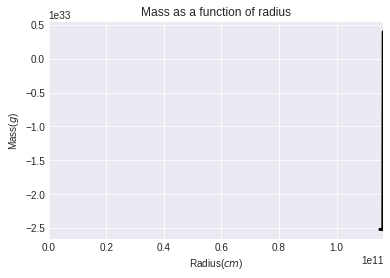

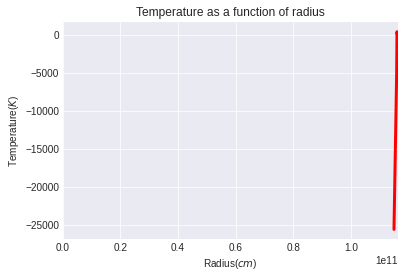

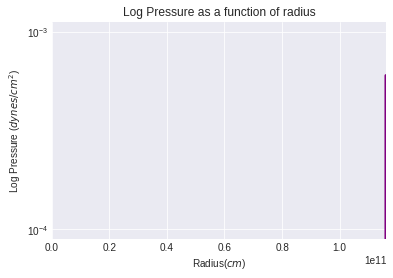

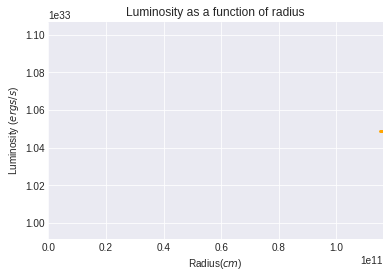

In [ ]:
### Cell created by Hunter ###
# For running

### sets the statstar parameters to parameters similar to the Sun.
#M = 1.0
#L = 1
#Te = 5780
#X = 0.73
#Z = 0.008


### sets the statstar parameters to protostar-like properties.
M = .2
L = 0.274202
Te = 3231.99
Z = .015
X = 1-.2780-Z


if Birthline == 'y':
  print('The modelled star will be pre-main-sequence. ')

else:
  print('The modelled star will be main-sequence. ')

Igoof,istop, M_r, L_r, T, P, rho, r = StatStar(M, L, Te, X, Z) ### Comment this out to set your own parameters
### This outputs a file called starmodl_py.dat to your colab directory with
### all the stellar data.


#Igoof,istop, M_r, L_r, T, P, rho, r = main() ### Comment this in to set your own parameters

# Plotting functions
MassPlot(M_r, r)
TempPlot(T, r)
PressurePlot(P,r)
LumPlot(L_r,r)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:211: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:219: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  2
 with the following conditions:
T =  -68567.84648264584  K
P =  nan  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  3
 with the following conditions:
T =  -102954.9309774529  K
P =  nan  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem 

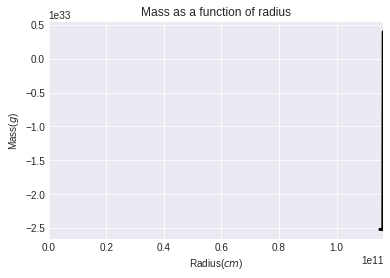

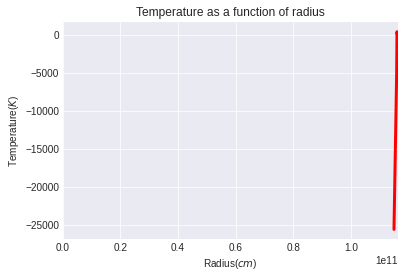

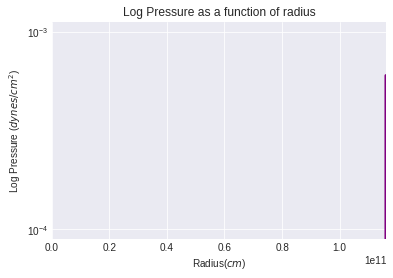

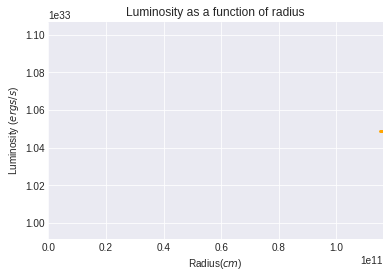

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:211: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:219: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  2
 with the following conditions:
T =  -60420.95968740176  K
P =  nan  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  3
 with the following conditions:
T =  -90722.34368309069  K
P =  nan  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem 

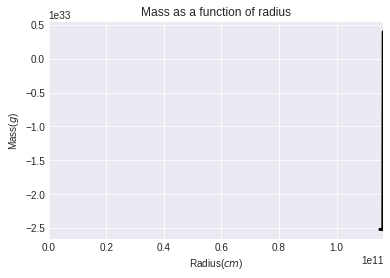

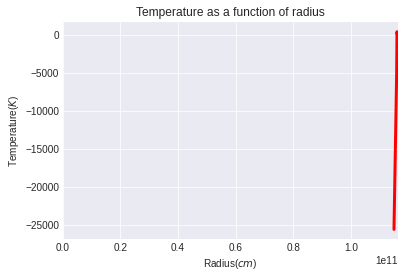

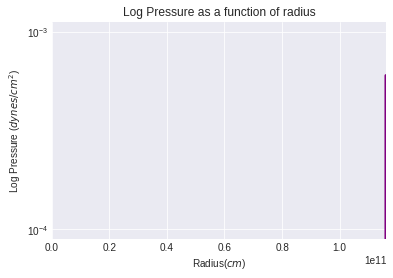

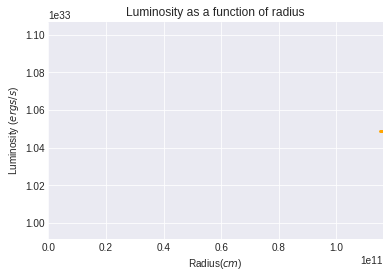

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:211: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:219: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  2
 with the following conditions:
T =  -77194.08030956141  K
P =  nan  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  3
 with the following conditions:
T =  -115907.2600034259  K
P =  nan  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem 

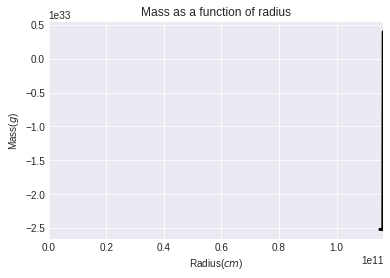

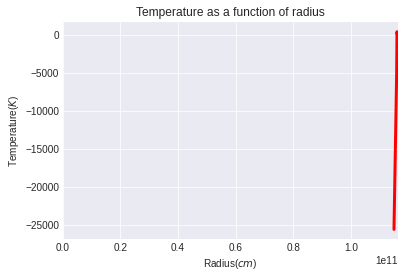

KeyboardInterrupt: ignored

In [ ]:
def Protostar_models(): # This function runs StatStar on all the Birthline objects I have.
  models = pd.read_csv("/content/gdrive/MyDrive/PHYS 486/Final Project/Birthline.csv")
  
  masses = models['Mass'] # puts all the masses in an array
  lums = models['L'] # puts all the luminosities in an array
  temps = models['T Eff'] # puts all the temperatures in the array
  X = 0.7 # set X and Z to be these for simplicity as getting them from the birthline files is hard
  Z = .008

  #print(masses)

  # runs Statstar on all the models in order
  for i in range(len(models)):

    M = masses[i]
    L = lums[i]
    Te = temps[i]

    StatStar(M, L, Te, X, Z)
    MassPlot(M_r, r)
    TempPlot(T, r)
    PressurePlot(P,r)
    LumPlot(L_r,r)

#Protostar_models()